# **Fingerprint thinning**

In [30]:
from KMM import KMM
from morphology import morphology_thinning
import numpy as np
from PIL import Image
import cv2
from IPython.display import display


In [31]:
def perform_thinning(
    path: str, 
    show_by_iterations: bool = False, 
    algorithm: str = 'KMM',
    show: bool = True,
    correct_thinning: bool = True
    ) -> np.ndarray:
    
    algs = {
        'KMM': KMM,
        'morphology': morphology_thinning
    }
    
    if algorithm not in algs:
        raise ValueError(f"Unknown algorithm: {algorithm}. Available algorithms: {list(algs.keys())}")

    alg = algs[algorithm]
    farray = read_bmp(path)
    
    if show:
        img = Image.fromarray(farray)
        print("Original Image")
        display(img)
    
    skeleton = alg(farray, show=show_by_iterations)

    if show:
        img_skeleton = skeleton.copy()
        img_skeleton[skeleton == 0] = 255
        img_skeleton[skeleton == 1] = 0


        img_skeleton = img_skeleton.astype(np.uint8)
        img = Image.fromarray(img_skeleton)
        print("\nThinned Image")
        display(img)  
        
    if correct_thinning:
        skeleton = correct(skeleton)    
        img_skeleton = skeleton.copy()
        img_skeleton[skeleton == 0] = 255
        img_skeleton[skeleton == 1] = 0


        img_skeleton = img_skeleton.astype(np.uint8)
        img = Image.fromarray(img_skeleton)
        print("\nThinned Image after Morphological Correction")
        display(img) 
      
    return skeleton

    
def read_bmp(path: str) -> np.ndarray:
    image = Image.open(path)
    image_np = np.array(image)
    _, farray = cv2.threshold(image_np, 127, 255, cv2.THRESH_BINARY)
    if farray.ndim == 3:
        farray = farray[:, :, 0]
    return farray


def correct(skeleton: np.ndarray) -> np.ndarray:
    skeleton = (skeleton > 0).astype(np.uint8)
    out = skeleton.copy()
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    out = cv2.morphologyEx(out, cv2.MORPH_DILATE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_DILATE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    out = cv2.morphologyEx(out, cv2.MORPH_DILATE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_DILATE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    out = cv2.morphologyEx(out, cv2.MORPH_ERODE, k)
    return out

# **Example**

Original Image


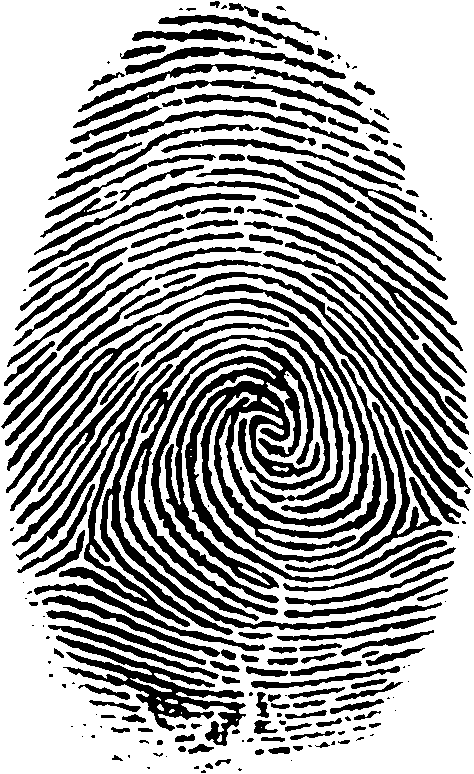

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8

Thinned Image


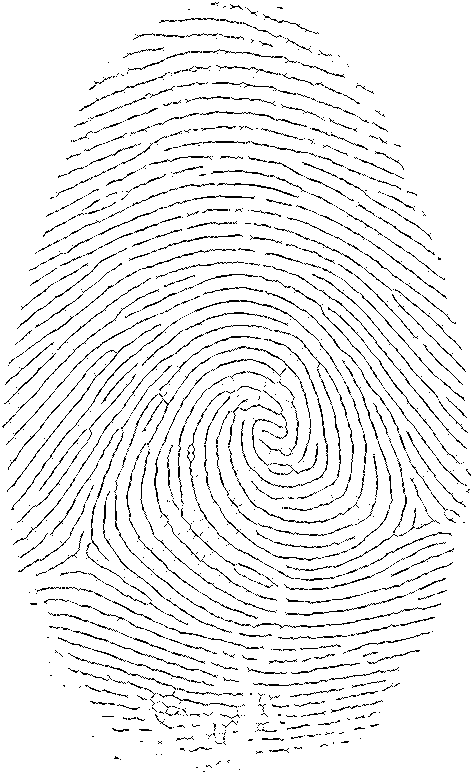


Thinned Image after Morphological Correction


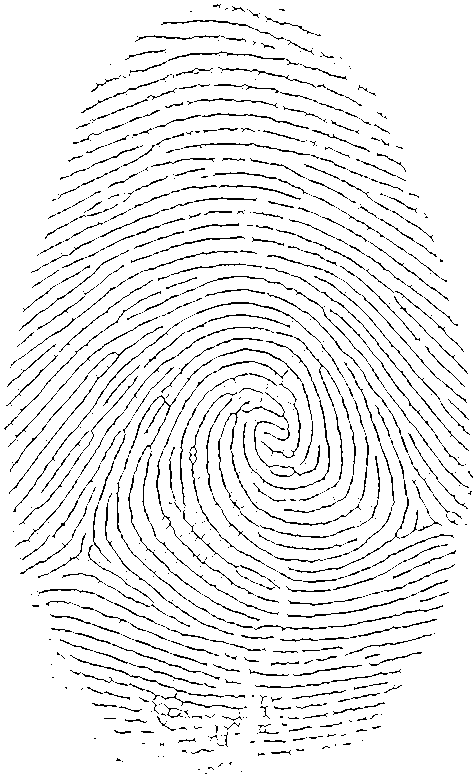

In [32]:
tester = 'test_data/tester.bmp'
skeleton = perform_thinning(path=tester, 
                            show_by_iterations=False,
                            show=True, 
                            algorithm='morphology',
                            correct_thinning=True)

# **Minutiae detection**

In [33]:

def detect_minutiae(skel: np.ndarray, circle_radius: int = 2, alpha: float = 0.09) -> dict:
    """
    Wykrywa minutie typu ending i bifurkation na szkielecie (0=tło,1=linia),
    rysuje półprzezroczyste kółka o promieniu `circle_radius` z przezroczystością `alpha`,
    zwraca słownik {(x,y): typ}.
    """
    assert skel.dtype == np.uint8 and set(np.unique(skel)).issubset({0,1})
    h, w = skel.shape

    # podkład do rysowania
    base = np.full((h, w, 3), 255, np.uint8)
    base[skel == 1] = (0, 0, 0)
    vis = base.copy()

    minutiae = {}
    def crossing_number(x, y):
        nbr = [int(skel[x+dx, y+dy]) for dx,dy in
               [(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1),(1,0),(1,1)]]
        return sum(abs(nbr[i] - nbr[(i+1)%8]) for i in range(8)) // 2

    for x in range(1, h-1):
        for y in range(1, w-1):
            if skel[x, y] != 1:
                continue
            cn = crossing_number(x, y)
            if cn == 1:
                typ, color = 'ending', (0, 0, 255)
            elif cn == 3:
                typ, color = 'bifurcation', (255, 0, 0)
            else:
                continue

            minutiae[(x, y)] = typ

            # rysujemy na nakładce
            overlay = vis.copy()
            cv2.circle(overlay, (y, x), circle_radius, color, thickness=-1)
            # blendujemy
            cv2.addWeighted(overlay, alpha, vis, 1 - alpha, 0, vis)

    # wyświetl wynik
    display(Image.fromarray(vis))
    return minutiae

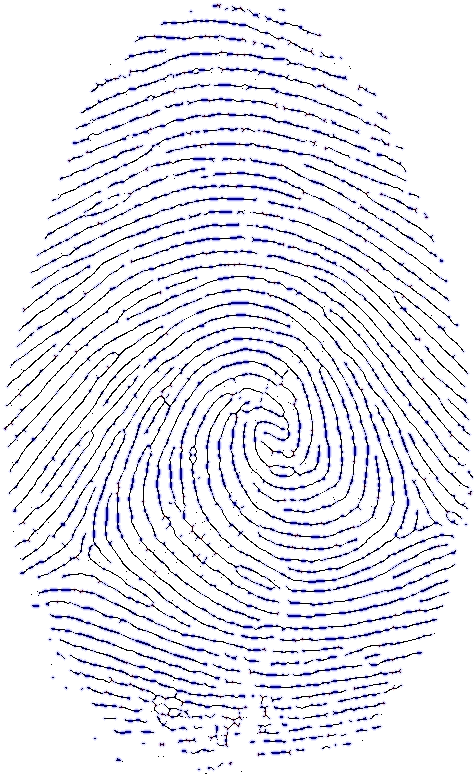

{(4, 217): 'ending',
 (4, 220): 'ending',
 (5, 213): 'ending',
 (5, 214): 'ending',
 (5, 215): 'ending',
 (5, 217): 'bifurcation',
 (5, 219): 'bifurcation',
 (6, 213): 'ending',
 (6, 214): 'ending',
 (6, 215): 'ending',
 (6, 216): 'ending',
 (6, 232): 'ending',
 (7, 219): 'ending',
 (7, 240): 'ending',
 (8, 227): 'ending',
 (8, 235): 'ending',
 (8, 240): 'bifurcation',
 (9, 225): 'ending',
 (9, 235): 'ending',
 (9, 236): 'ending',
 (9, 279): 'ending',
 (9, 283): 'ending',
 (10, 232): 'ending',
 (10, 249): 'ending',
 (10, 282): 'ending',
 (10, 284): 'ending',
 (11, 190): 'ending',
 (11, 191): 'ending',
 (11, 244): 'ending',
 (14, 254): 'ending',
 (14, 255): 'ending',
 (14, 256): 'ending',
 (14, 257): 'ending',
 (15, 253): 'ending',
 (15, 254): 'ending',
 (15, 255): 'ending',
 (15, 256): 'ending',
 (16, 265): 'ending',
 (17, 258): 'ending',
 (18, 268): 'ending',
 (18, 269): 'ending',
 (18, 270): 'ending',
 (19, 267): 'ending',
 (19, 268): 'ending',
 (19, 269): 'ending',
 (20, 193): 'endi

In [34]:
detect_minutiae(skeleton)